In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

In [3]:
simulated_dir = Path('../output/simulated5_reproduction')
assert simulated_dir.exists()

# Common Functions

In [4]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['RPsoft']['all']
    print(f'Good:Bad = {s["good"]}:{s["bad"]}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [5]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

In [6]:
def summarize_results(config_name, folds=5):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        report_list.append(r)
    df = pd.DataFrame(columns=['dataset', 'model', 'auc', 'auc_std', 'r1_good', 'r1_goodbad', 'r2', 'r2_std'])
    for r in report_list:
        row = {
            'dataset':   r['config']['config_name'],
            'model':     r['config']['exp_name'],
            'auc':       mean([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]),
            'auc_std':   stdev([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]) if folds > 1 else np.nan,
            'r1_good':       r['indicator']['RPsoft']['all']['good'],
            'r1_goodbad':       r['indicator']['RPsoft']['all']['good'] + r['indicator']['RPsoft']['all']['bad'],
            'r2':      mean(r['indicator']['RPhard']['all']),
            'r2_std': stdev(r['indicator']['RPhard']['all'])
        }
        df = df.append(row, ignore_index=True)
    return df
        

## Learning curve

In [7]:
def lc_plot(config_name, config_path):
    report_list = []
    r = load_json(config_path)
    idclist_dic = r['indicator']
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    auc = []
    for _y in idclist_dic['eval_auc'].values():
        auc += _y[:min_len]
        
    loss = []
    for _y in idclist_dic['eval_loss'].values():
        loss += _y[:min_len]
    #print(len(auc))
    #print(len(x))
    sns.lineplot(x=x, y=auc, label=r['config']['exp_name'], ci='sd')
    sns.lineplot(x=x, y=loss, label=r['config']['exp_name'], ci='sd')
    
    plt.title(config_name)
    plt.xlabel('epoch')
    plt.ylabel('AUC')
    plt.show()

In [8]:
def report_path(version, date_str):
    return simulated_dir / version / 'report/' / date_str / 'report.json'

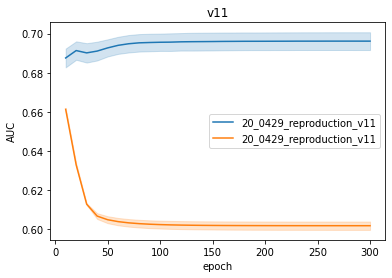

In [84]:
v11 = report_path('20_0429_reproduction_v11', '20200501-0040') 
lc_plot('v11', v11)

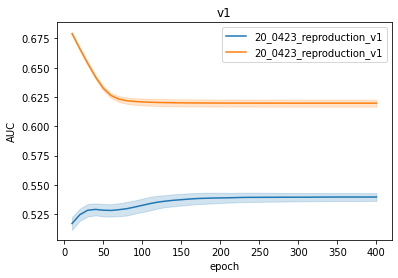

In [85]:
v1 = report_path('20_0423_reproduction_v1', '20200423-0051') 
lc_plot('v1', v1)

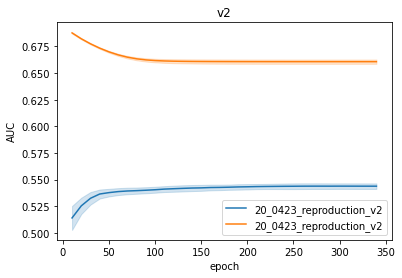

In [86]:
v2 = report_path('20_0423_reproduction_v2', '20200423-0155') 
lc_plot('v2', v2)

In [ ]:
v3 = report_path('20_0423_reproduction_v3', '20200423-0248') 
lc_plot('v3', v3)

In [ ]:
v4 = report_path('20_0423_reproduction_v4', '20200423-0259') 
lc_plot('v4', v4)

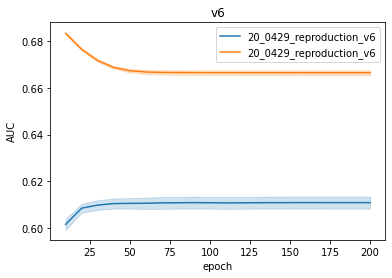

In [94]:
v6 = report_path('20_0429_reproduction_v6', '20200429-1736') 
lc_plot('v6', v6)

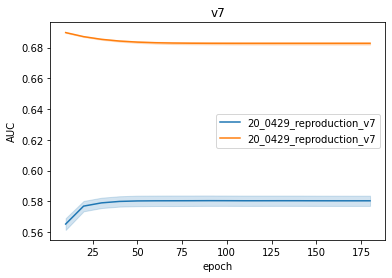

In [95]:
v7 = report_path('20_0429_reproduction_v7', '20200429-1753') 
lc_plot('v7', v7)

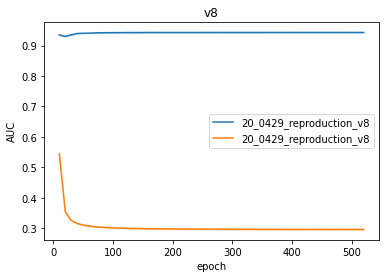

In [97]:
v8 = report_path('20_0429_reproduction_v8', '20200430-2058') 
lc_plot('v8', v8)

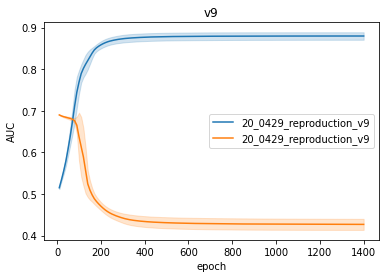

In [98]:
v9 = report_path('20_0429_reproduction_v9', '20200430-2102') 
lc_plot('v9', v9)

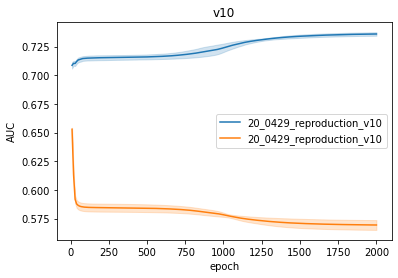

In [100]:
v10 = report_path('20_0429_reproduction_v10', '20200520-2327') 
lc_plot('v10', v10)

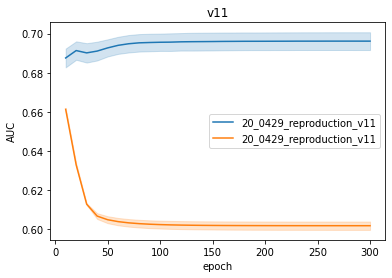

In [99]:
v11 = report_path('20_0429_reproduction_v11', '20200501-0040') 
lc_plot('v11', v11)

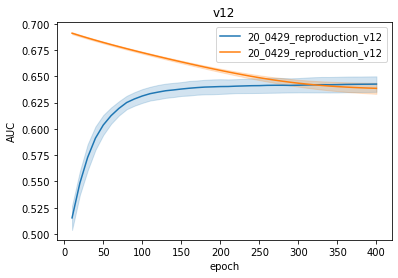

In [9]:
v12 = report_path('20_0429_reproduction_v12', '20200528-1255') 
lc_plot('v12', v12)

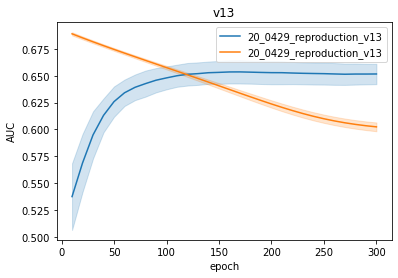

In [10]:
v13 = report_path('20_0429_reproduction_v13', '20200528-1310') 
lc_plot('v13', v13)